Watch out, fewer helpful comments this time and I changed a few design matrix calls to make things sparser, and take up less of your memory!

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm.notebook import tqdm
import warnings

from astropy.timeseries import lombscargle

# We'll need this later
def vstack(dms):
    """ Custom vertical stack script 
    """
    npoints = np.sum([dm.shape[0] for dm in dms])
    ncomps = np.sum([dm.shape[1] for dm in dms])
    if sparse.issparse(dms[0].X):
        X = sparse.lil_matrix((npoints, ncomps))
    else:
        X = np.zeros((npoints, ncomps))
    idx = 0
    jdx = 0
    for dm in dms:
        X[idx:idx+dm.shape[0], jdx:jdx+dm.shape[1]] += dm.X
        idx = idx + dm.shape[0]
        jdx = jdx + dm.shape[1]
    prior_mu = np.hstack([dm.prior_mu for dm in dms])
    prior_sigma = np.hstack([dm.prior_sigma for dm in dms])
    name = dms[0].name
    if sparse.issparse(dms[0].X):
        return lk.SparseDesignMatrix(X.tocsr(), name=name, prior_mu=prior_mu, prior_sigma=prior_sigma)
    else:
        return lk.DesignMatrix(X, name=name, prior_mu=prior_mu, prior_sigma=prior_sigma)

In [2]:
sr = lk.search_targetpixelfile('TIC 150428135', mission='tess')

In [3]:
tpfs = sr.download_all()

In [4]:
#tpfs = sr.download_all()
tpfs_uncorr = [(tpf + np.nan_to_num(tpf.flux_bkg))[np.isfinite(tpf.flux_bkg.sum(axis=(1, 2)))] for tpf in tpfs]

In [5]:
bigger_apers = [(np.asarray(np.gradient(tpf.pipeline_mask.astype(int))) != 0).any(axis=0) | tpf.pipeline_mask for tpf in tpfs_uncorr]

In [6]:
lc = lk.LightCurveCollection([tpf.to_lightcurve(aperture_mask=aper) for tpf, aper in zip(tpfs_uncorr, bigger_apers)]).stitch()
lc.flux_err[~np.isfinite(lc.flux_err)] = np.nanmedian(lc.flux_err)

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bkgs = [lk.DesignMatrix(tpf.flux[:, ~aper], name='bkg').pca(3).append_constant().to_sparse() for tpf, aper in zip(tpfs_uncorr, bigger_apers)]
    for bkg in bkgs:
        bkg.prior_mu[-1] = 1
        bkg.prior_sigma[-1] = 0.1
        
        bkg.prior_mu[:-1] = 0
        bkg.prior_sigma[:-1] = 1000

        
    # Split at the downlink
#    bkgs = [bkg.split(list((np.where((np.diff(tpf.time) > 0.3))[0] + 1))) for bkg, tpf in zip(bkgs, tpfs_uncorr)]
systematics_dm = vstack(bkgs)

This time, we're using a design matrix of sines and cosines to look for periodicities

In [8]:
period = 50
ls_dm = lk.DesignMatrix(lombscargle.implementations.mle.design_matrix(lc.time, frequency=1/period, bias=False, nterms=1), name='LS').to_sparse()

In [9]:
dm = lk.SparseDesignMatrixCollection([systematics_dm, ls_dm]).to_designmatrix(name='design_matrix')

In [10]:
# We call regression corrector once, making it again and again is expensive.
reg = lk.RegressionCorrector(lc)

In [11]:
# Loop over some periods we might care about
periods = np.linspace(10, 120, 100)
ws = np.zeros((len(periods), 2))
for idx, period in enumerate(tqdm(periods)):
    dm.X[:, -2:] = lombscargle.implementations.mle.design_matrix(lc.time, frequency=1/period, bias=False, nterms=1)
    _ = reg.correct(dm, sigma=8)
    ws[idx] = reg.coefficients[-2:]

Text(0, 0.5, '"Power" by some definition')

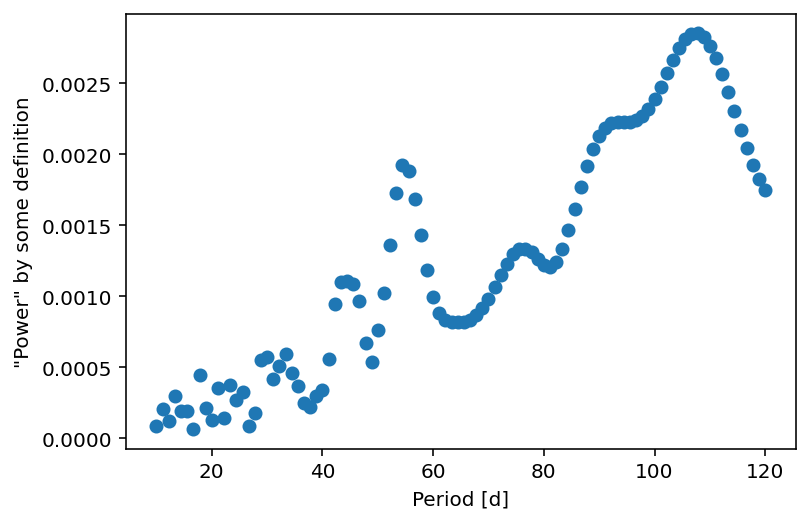

In [12]:
plt.scatter(periods, (ws[:, 0]**2+ws[:, 1]**2)**0.5)
plt.xlabel('Period [d]')
plt.ylabel('"Power" by some definition')